# Syrtis Demonstration - Martian Environment
# Variations in Heat Loss over a Martian Day

This example shows another feature of Syrtis that allows for rapid calculation of many values - the `DayManager` tool. This initialises and runs a series of simulations for a single habitat geometry, each at a different time of a solar day. `DayManager` thus provides the ability to see how a habitat design will fare across an entire sol, rather than just at a static point in time. It also automatically corrects for atmospheric attenuation, reduced sunlight at higher latitudes and variability in daily temperature.

In [1]:
from syrtis import *
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np
import matplotlib.pyplot as plt

### Setup and Configuration
The same geometry as the Mars Direct - Vertical HAB is used. Note that shiny aluminium is used, which has a high ratio of solar absorbance to emittance. For long duration missions it may be required to consider the radiative properties of aluminium with a fine coating of Martian dust. 

Instead of the generic Martian equator location, the landing point of the Curiosty rover is used - as this allows the use of air/ground temperature measurements from REMS weather station instrument.

In [2]:
# Materials definitions
# The absorbivity of perlite and air are assumed as 0.5 but are not required
aluminium = Solid("Aluminium", 247, 2700, 900, absorb=0.15, emit=0.04)
plastic = Solid("Generic plastic", 10, 1300, 1420, absorb=0.89, emit=0.84)

internal_air = ConstrainedIdealGas("STP Air", 101325, 29, 0.71, 17.9e-6, 1010, 0.0252)
martian_air = ConstrainedIdealGas("Martian ambient pressure CO2", 580, 44, 0.71, 10.9e-6, 749, 0.0153)

mount_sharp = Configuration("Curiosity landing area, Mount Sharp",
 "constant temperature", 210, 0.2, 0.29, 210, 580, 5, "cross", 90, 90, 590, T_habitat=293)

In [3]:
HAB_vertical = Habitat(orientation="vertical", length=8, endcap_type="flat")

HAB_vertical.create_static_shell(internal_air, 4.400)
HAB_vertical.create_static_shell(aluminium, 4.8e-3)

HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.5e-5)
# Parallel resistance corresponds to 1% of the cross-section being aluminium

HAB_vertical.create_static_shell(plastic, 12e-3)
HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.4e-5)

HAB_vertical.create_static_shell(aluminium, 2e-3)

HAB_vertical.create_ground_level(thermal_resistance=1)
# Thermal resistance roughly corresponds to six aluminium landing legs, each 5m long and with 50cm2 area

## DayManager Creation

`DayManager` objects are created for both a winter and summer case, with different values of areocentric longitude. This is an orbital parameter, commonly denoted as $L$ which describes the position of Mars in the orbit. $L=90$ corresponds to midwinter in the Southern hemisphere, $L=270$ corresponds to midsummer. The seasonal variation on minimum and maximum air temperature is taken from the Curiosity REMS instument, retrieved from the Planetary Data Service. $L=270$ data taken from Curiosity Sol 53 and for $L=90$ Sol 554, with a 30-minute moving average used to capture the approximate maximum and minimum temperature of the ground and air.

"Gomez-Elvira, J., Mars Science Laboratory Rover Environmental Monitoring Station RDR Data V1.0, MSL-M-REMS-4-ENVEDR-V1.0, NASA Planetary Data System, 2013."

In [4]:
summer_data = DayManager(HAB_vertical, mount_sharp, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=270,
    T_air_max=270, T_air_min=195, T_ground_max=298, T_ground_min=170, time_air_peak=15.3, time_ground_peak=12.8)

winter_data = DayManager(HAB_vertical, mount_sharp, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=90,
    T_air_max=250, T_air_min=165, T_ground_max=195, T_ground_min=110, time_air_peak=15.2, time_ground_peak=12.8)

Before we examine the solutions, some of the parameters of the daily and seasonal variation can be plotted.

The approximation to daily temperature variation is shown below. Two curves are combined to make this fit - a sinusoidal curve during daylight, which starts at the coldest point of the day (just before sunrise) and continues to sunset. The temperature then drops linearly from sunset to the following sunrise. This is a good fit for the data observed by various spacecraft.

Text(0.5, 1.0, 'Variation of ground and air temperature over midsummer day')

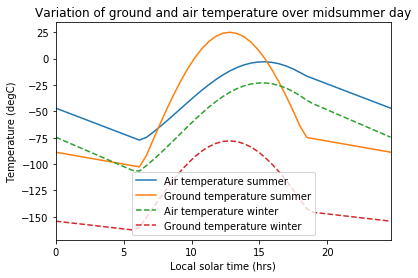

In [5]:
plt.plot(summer_data.times, [i-273 for i in summer_data.T_airs], label="Air temperature summer")
plt.plot(summer_data.times, [i-273 for i in summer_data.T_grounds], label="Ground temperature summer")
plt.plot(winter_data.times, [i-273 for i in winter_data.T_airs], "--", label="Air temperature winter")
plt.plot(winter_data.times, [i-273 for i in winter_data.T_grounds], "--", label="Ground temperature winter")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Temperature (degC)")
plt.title("Variation of ground and air temperature over midsummer day")

Text(0.5, 1.0, 'Variation of solar altitude between summer and winter')

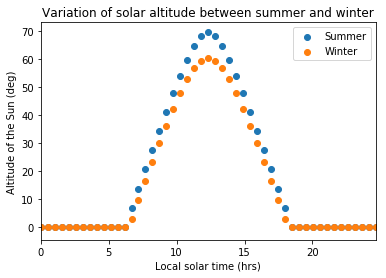

In [6]:
plt.scatter(summer_data.times, summer_data.solar_altitudes, label="Summer")
plt.scatter(winter_data.times, winter_data.solar_altitudes, label="Winter")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Altitude of the Sun (deg)")
plt.title("Variation of solar altitude between summer and winter")

Text(0.5, 1.0, 'Variation of solar intensity between summer and winter')

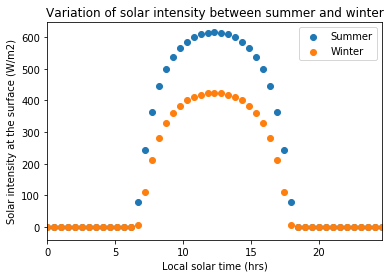

In [7]:
plt.scatter(summer_data.times, summer_data.solar_intensities, label="Summer")
plt.scatter(winter_data.times, winter_data.solar_intensities, label="Winter")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Solar intensity at the surface (W/m2)")
plt.title("Variation of solar intensity between summer and winter")

## Results

With the exposition on `DayManager` out of the way, we can drill down into the results of the simulations.

In [8]:
summer_configs, summer_heats, summer_reports = summer_data.run_all_configurations(verbose=True)

winter_configs, winter_heats, winter_reports = winter_data.run_all_configurations(verbose=True)

The variations in heat loss across a day are shown below. Predictably, both winter and summer experience the most heat loss when the sun is still down and the air/ground are coldest. The lowest heat loss is just after midday. The increased environment temperatures and stronger sunlight during summer mean heat loss temporarily dips negative (meaning heat is being gained) for around ten hours in the middle of the way. Neither habitat is able to gain heat when the sun is down.

Text(0.5, 1.0, 'Daily variation in heat loss from habitat, summer and winter')

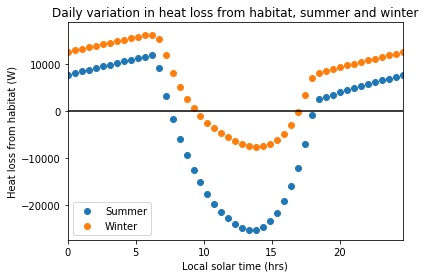

In [9]:
plt.figure(figsize=(6,4))

plt.scatter(summer_data.times, summer_heats, label="Summer")
plt.scatter(winter_data.times, winter_heats, label="Winter")

plt.legend()
plt.axhline(0, color='black')
plt.xlim(0, 24.65)



plt.xlabel("Local solar time (hrs)")
plt.ylabel("Heat loss from habitat (W)")
plt.title("Daily variation in heat loss from habitat, summer and winter")

Using the power balance bar chart, we can drill down into the exact sources of heat loss and gain at different points in the day and year.

The major differences that cause greater heat gain during winter nights are the lower air and ground temperatures - these cause greater losses to radiation and convection. The habitat loses around 5kW more in winter than summer.

The dramatic difference is at noon, where both habitats gain heat rather than lose it. This is in large part due to the high ratio of absorbance to emittance of the shiny aluminium outer skin - this absorbs a large fraction of incoming thermal radiation and emits very little. The difference between winter and summer can be seen to be largely due to the increased temperatures of the surrounding ground - not the greater solar intensity as may be expected. All other differences are relatively small but the ground temperature causes a 5-fold increase in radiative gain.

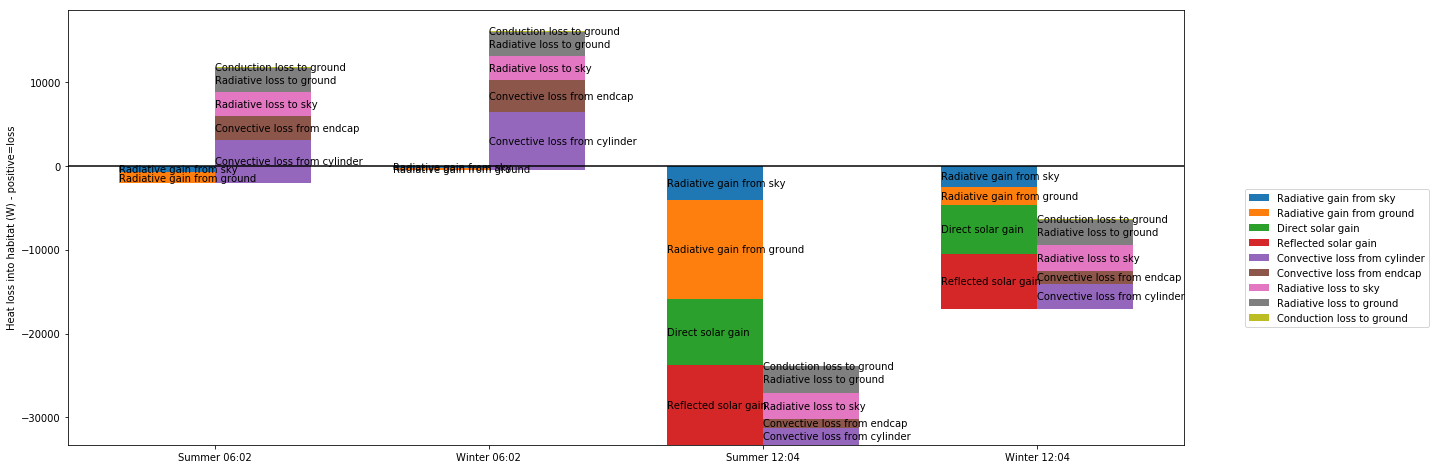

In [10]:
plt.figure(figsize=(20,8))
tools.plot_power_balance([summer_reports[12], winter_reports[12], summer_reports[24], winter_reports[24]], 
    labels=["Summer 06:02", "Winter 06:02", "Summer 12:04", "Winter 12:04"])

## Net energy gain and constant-power

It can be noted that the heat gain into the habitat during summer is so great, the overall energy balance over one sol is positive. This is shown exactly below.

Given this, it may be desirable to explore the transient behaviour of the habitat with a constant internal heat load. The internal temperature should fluctuate substantially, although the thermal mass of the structure may alleviate this somewhat.

In the summer case, let us consider the habitat with zero heating. For the winter case, the daily net energy balance is a loss of around 150kWh so a constant heat load of 6.2kW can be used.

In [11]:
print("Daily energy balance in summer: {:.2f}kWh".format(sum(summer_heats) * 24.65/49 / 1000))
print("Daily energy balance in winter: {:.2f}kWh".format(sum(winter_heats) * 24.65/49 / 1000))

Daily energy balance in summer: -71.93kWh
Daily energy balance in winter: 151.53kWh


In [12]:
mount_sharp_constant_power_summer = Configuration("Curiosity landing area, Mount Sharp",
 "constant power", 210, 0.2, 0.29, 210, 580, 5, "cross", 90, 90, 590, Q_habitat=1100)
mount_sharp_constant_power_winter = Configuration("Curiosity landing area, Mount Sharp",
 "constant power", 210, 0.2, 0.29, 210, 580, 5, "cross", 90, 90, 590, Q_habitat=6200)

summer_constant_power = DayManager(HAB_vertical, mount_sharp_constant_power_summer, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=270,
    T_air_max=270, T_air_min=195, T_ground_max=298, T_ground_min=170, time_air_peak=15.3, time_ground_peak=12.2)

winter_constant_power = DayManager(HAB_vertical, mount_sharp_constant_power_winter, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=90,
    T_air_max=250, T_air_min=165, T_ground_max=195, T_ground_min=110, time_air_peak=15.2, time_ground_peak=12.1)

In [13]:
summer_cp_configs, summer_cp_heats, summer_cp_reports = summer_constant_power.run_all_configurations(verbose=True)

winter_cp_configs, winter_cp_heats, winter_cp_reports = winter_constant_power.run_all_configurations(verbose=True)

Did not converge 2.6729751339981016 [416.90245724 416.90245724 416.90236064 416.80939903 416.80351206
 416.71164521 416.71160599] -1840.2726473979121
Did not converge 5.532155527630012 [431.02551683 431.02551683 431.02542023 430.93245862 430.92657165
 430.83470479 430.83466557] -4985.3710803930135
Did not converge 7.311752647286034 [439.48258237 439.48258237 439.48248577 439.38952415 439.38363719
 439.29177033 439.29173111] -6942.9279120146375
Did not converge 8.257317839650154 [443.86611286 443.86611286 443.86601626 443.77305465 443.76716768
 443.67530082 443.6752616 ] -7983.04962361517
Did not converge 8.332786094720738 [444.18468227 444.18468227 444.18458567 444.09162405 444.08573709
 443.99387023 443.99383101] -8066.064704192811
Did not converge 7.376757797681011 [439.69403383 439.69403383 439.69393723 439.60097562 439.59508865
 439.50322179 439.50318257] -7014.433577449112
Did not converge 5.1879106681619 [429.19593471 429.19593471 429.19583811 429.1028765  429.09698953
 429.00512

Text(0.5, 1.0, 'Daily variation in heat loss from habitat, summer and winter')

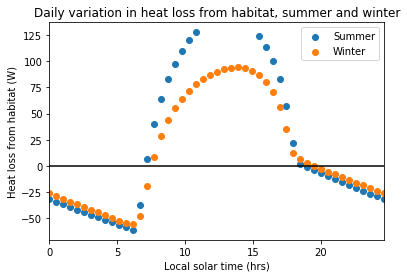

In [14]:
plt.figure(figsize=(6,4))

plt.scatter(summer_data.times, [report["Inner wall temperature"]-273 for report in summer_cp_reports], label="Summer")
plt.scatter(summer_data.times, [report["Inner wall temperature"]-273 for report in winter_cp_reports], label="Winter")

plt.legend()
plt.axhline(0, color='black')
plt.xlim(0, 24.65)



plt.xlabel("Local solar time (hrs)")
plt.ylabel("Heat loss from habitat (W)")
plt.title("Daily variation in heat loss from habitat, summer and winter")